In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from utils.sampler import sample
from components.classes import NameDataset, MinimalTransformer
import json

# Data analysis

In [2]:
male_dataset = pd.read_csv('data/pop_vardai_vyrai.txt',delimiter=' ',encoding="UTF-16")
female_dataset = pd.read_csv('data/pop_vardai_moterys.txt',delimiter=' ',encoding="UTF-16")

In [3]:
print(male_dataset)

            name  popularity
0           Abas           0
1        Abdijus           0
2        Abdonas           0
3         Abdula           0
4         Abelis           2
...          ...         ...
3845  Žigimantas          25
3846  Žigymantas           0
3847    Žigintas           0
3848    Žilvynas           0
3849    Žimantas           0

[3850 rows x 2 columns]


In [4]:
print(female_dataset.shape)
print(male_dataset.shape)

(4235, 2)
(3850, 2)


We have around 8085 names total. How many of those are 0? How many are >100?

In [45]:
print(f"Number of male names with 0 popularity: {(male_dataset['popularity']==0).sum()}")
print(f"Number of male names with >=100 popularity: {(male_dataset['popularity']>=100).sum()}")
print(f"Max popularity for male name: {(male_dataset['popularity']).max()}")
print(f"Average popularity for male name: {(male_dataset['popularity']).mean().round(2)}\n")
print(f"Number of female names with 0 popularity: {(female_dataset['popularity']==0).sum()}")
print(f"Number of female names with >=100 popularity: {(female_dataset['popularity']>=100).sum()}")
print(f"Max popularity for female name: {(female_dataset['popularity']).max()}")
print(f"Average popularity for female name: {(female_dataset['popularity']).mean().round(2)}")

print(f"Longest male name: {male_dataset['name'].loc[male_dataset['name'].str.len().idxmax()]}")
print(f"Longest female name: {female_dataset['name'].loc[female_dataset['name'].str.len().idxmax()]}")

Number of male names with 0 popularity: 1391
Number of male names with >=100 popularity: 404
Max popularity for male name: 17236
Average popularity for male name: 141.73

Number of female names with 0 popularity: 1583
Number of female names with >=100 popularity: 499
Max popularity for female name: 11642
Average popularity for female name: 164.3
Longest male name: Maksimilijonas
Longest female name: Neužmirštuolė


There are a lot of names with 0 popularity in both datasets. These names are either improper, foreign or otherwise unused in the modern naming scheme.

For the sake of a more accurate model, we will be omiting names with 0 popularity.

Additionally, we will try to see what kind of model we can get if we take the n most popular names as the training data.

For the sake of curiosity, let's see how the distribution of name popularities looks like in intervals.

[0,10], [11,100], [101,1000], [1001,2000], [2001,5000], [5000,10000], [10000,20000]

In [6]:
bins = [0,10,100,1000,2000,5000,10000,20000]
labels = ["[0;10]","[11;100]","[101;1000]","[1001;2000]","[2001;5000]","[5001;10000]","[10001;20000]"]
merged_names = pd.concat([male_dataset,female_dataset],ignore_index=True)
merged_names['popularity_bin'] = pd.cut(merged_names['popularity'],bins=bins,labels=labels)
interval_counts = merged_names['popularity_bin'].value_counts().sort_index()
print(interval_counts)

popularity_bin
[0;10]           3089
[11;100]         1126
[101;1000]        602
[1001;2000]       120
[2001;5000]       118
[5001;10000]       47
[10001;20000]       9
Name: count, dtype: int64


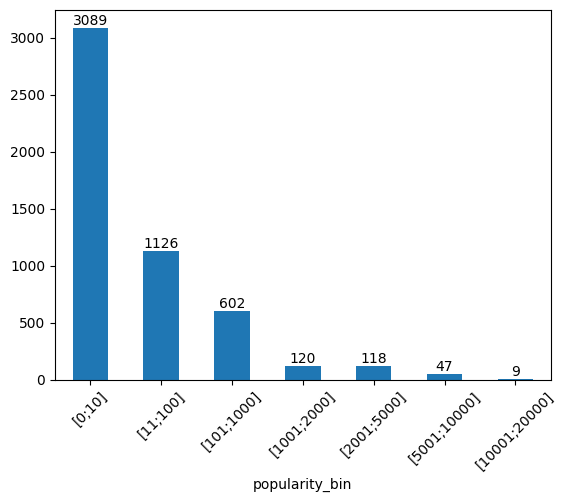

In [7]:
ax = interval_counts.plot(kind='bar')
plt.xticks(rotation=45)
for i, value in enumerate(interval_counts):
    ax.text(i, value + 0.2, str(value), ha='center', va='bottom', fontsize=10)

Top 500 popular names (seperate for male and female)

In [8]:
male_sorted = male_dataset.sort_values(by='popularity',ascending=False)
female_sorted = female_dataset.sort_values(by='popularity',ascending=False)

top_500_male=male_sorted.head(500)
top_500_female = female_sorted.head(500)

In [9]:
top_500_male

,name,popularity
2278,Lukas,17236
2330,Mantas,12171
3368,Tomas,10842
2366,Matas,10601
904,Dovydas,8654
...,...,...
1114,Emetas,58
3275,Taironas,56
2620,Nikodemas,56
2270,Lorenas,56


In [10]:
top_500_female

,name,popularity
1497,Gabrielė,11642
1804,Gabriele,11642
3939,Viktorija,10711
1494,Gabija,10425
1870,Ieva,10212
...,...,...
3761,Terese,103
3749,Terėsė,103
3463,Severina,102
106,Akvilina,100


# Namesformer model

We will be making 4 different models:
1. All-model. It will take all the name data.
2. Partial-model. It will take all names, which have >0 popularity.
3. Popular_1000-model. It will take the top 1000 most popular names as its training data.
4. Popular_500-model. It will take the top 500 most popular names as its training data.

The models will be trained seperately on female data and male data, thus there will be a total of 8 models.

NameDataset was modified to accomodate directly giving it a dataframe.

In [21]:
male_dataset = pd.read_csv('data/pop_vardai_vyrai.txt',delimiter=' ',encoding="UTF-16")
female_dataset = pd.read_csv('data/pop_vardai_moterys.txt',delimiter=' ',encoding="UTF-16")
male_sorted = male_dataset.sort_values(by='popularity',ascending=False)
female_sorted = female_dataset.sort_values(by='popularity',ascending=False)

male_dataset_nozero = male_dataset[male_dataset['popularity']>0]
female_dataset_nozero = female_dataset[female_dataset['popularity']>0]

male_top1000 = male_sorted.head(1000)
female_top1000 = female_sorted.head(1000)

male_top500 = male_sorted.head(500)
female_top500 = female_sorted.head(500)


In [46]:
train_index = 0

training_datasets_male = [male_dataset,male_dataset_nozero,male_top1000,male_top500]
training_datasets_female = [female_dataset,female_dataset_nozero,female_top1000,female_top500]
chosen_dataset_m = training_datasets_male[train_index]['name'].str.lower().values
chosen_dataset_f = training_datasets_female[train_index]['name'].str.lower().values
dataset_m = NameDataset(chosen_dataset_m)
dataset_f = NameDataset(chosen_dataset_f)
print(chosen_dataset_f)

['abė' 'abigailė' 'abija' ... 'žiginta' 'žimantė' 'ževile']


In [47]:
dataset_m.int_to_char

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: 'ą',
 27: 'č',
 28: 'ė',
 29: 'ę',
 30: 'š',
 31: 'ū',
 32: 'ž'}

In [48]:
[dataset_f.int_to_char[num] for num in dataset_f[0].numpy()]

['a', 'b', 'ė', ' ']

In [49]:
def pad_collate(batch):
    padded_seqs = pad_sequence(batch, batch_first=True, padding_value=0)
    input_seq = padded_seqs[:, :-1]
    target_seq = padded_seqs[:, 1:]
    return input_seq, target_seq

dataloader_m = DataLoader(dataset_m, batch_size=32, shuffle=True, collate_fn=pad_collate)
dataloader_f = DataLoader(dataset_f, batch_size=32, shuffle=True, collate_fn=pad_collate)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [51]:
def train_model(model, dataloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        model.train()  # Ensure the model is in training mode
        total_loss = 0.0
        batch_count = 0

        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            optimizer.zero_grad()
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.transpose(1, 2), target_seq)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1

        average_loss = total_loss / batch_count
        print(f'Epoch {epoch+1}, Average Loss: {average_loss}')

In [ ]:

model_m = MinimalTransformer(vocab_size=dataset_m.vocab_size, embed_size=256, num_heads=8, forward_expansion=4)
model_f = MinimalTransformer(vocab_size=dataset_f.vocab_size, embed_size=256, num_heads=8, forward_expansion=4)
model_m = model_m.to(device)
model_f = model_f.to(device)

In [88]:
standard_epochs = 100

In [89]:
train_model(model_m, dataloader_m,epochs=standard_epochs)

Epoch 1, Average Loss: 1.3372438215027171
Epoch 2, Average Loss: 1.1751914383951299
Epoch 3, Average Loss: 1.1592051775987484
Epoch 4, Average Loss: 1.1455727805776044
Epoch 5, Average Loss: 1.1347911742107928
Epoch 6, Average Loss: 1.1435743801849934
Epoch 7, Average Loss: 1.1228217147598583
Epoch 8, Average Loss: 1.1247447275918376
Epoch 9, Average Loss: 1.1213686269176892
Epoch 10, Average Loss: 1.1234971816874733
Epoch 11, Average Loss: 1.1247132819546155
Epoch 12, Average Loss: 1.1078771830590304
Epoch 13, Average Loss: 1.1131137259735548
Epoch 14, Average Loss: 1.1078829873691907
Epoch 15, Average Loss: 1.1152338764884255
Epoch 16, Average Loss: 1.110936030376056
Epoch 17, Average Loss: 1.1153917982558574
Epoch 18, Average Loss: 1.111647535454143
Epoch 19, Average Loss: 1.1018211073126674
Epoch 20, Average Loss: 1.1093606397140126
Epoch 21, Average Loss: 1.1203925368214442
Epoch 22, Average Loss: 1.1123246456965927
Epoch 23, Average Loss: 1.1036824598785275
Epoch 24, Average Loss

In [90]:
train_model(model_f, dataloader_f,epochs=standard_epochs)

Epoch 1, Average Loss: 1.3495350784825204
Epoch 2, Average Loss: 1.21502289198395
Epoch 3, Average Loss: 1.1971078788427483
Epoch 4, Average Loss: 1.1934757259555329
Epoch 5, Average Loss: 1.1850562727540956
Epoch 6, Average Loss: 1.1838353173177045
Epoch 7, Average Loss: 1.1756133011409216
Epoch 8, Average Loss: 1.1644103612218584
Epoch 9, Average Loss: 1.169866210535953
Epoch 10, Average Loss: 1.1704126560598387
Epoch 11, Average Loss: 1.1682427261108743
Epoch 12, Average Loss: 1.1653294325771189
Epoch 13, Average Loss: 1.1762927757169968
Epoch 14, Average Loss: 1.1635268066162454
Epoch 15, Average Loss: 1.160960094373029
Epoch 16, Average Loss: 1.1616751695037784
Epoch 17, Average Loss: 1.159620267556126
Epoch 18, Average Loss: 1.1569665589726956
Epoch 19, Average Loss: 1.158946348760361
Epoch 20, Average Loss: 1.1528105968819524
Epoch 21, Average Loss: 1.1606136529069198
Epoch 22, Average Loss: 1.157054783258223
Epoch 23, Average Loss: 1.1519449447330676
Epoch 24, Average Loss: 1.1

# Sampling

In [91]:
model_m.to("cpu")
model_f.to("cpu")

MinimalTransformer(
  (embed): Embedding(32, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Drop

In [92]:
print('Male More confident:')
for _ in range(10):
    print(' ', sample(model_m, dataset_m, start_str='a', temperature=0.5))  # More confident

print('\n Male More diverse/creative:')
for _ in range(10):
    print(' ', sample(model_m, dataset_m, start_str='a', temperature=1.5))  # More diverse

Male More confident:
  audis
  aristas
  almas
  ainas
  animas
  augis
  arimilis
  aiktvydas
  aridis
  alilintijus

 Male More diverse/creative:
  armilasijus
  arvmeid
  arozed
  avmielarejus
  aimirt
  azbemacijus
  arnaldala
  abvem
  aj
  adijot


In [93]:
print('Female More confident:')
for _ in range(10):
    print(' ', sample(model_f, dataset_f, start_str='a', temperature=0.5))  # More confident

print('\n Female More diverse/creative:')
for _ in range(10):
    print(' ', sample(model_f, dataset_f, start_str='a', temperature=1.5))  # More diverse

Female More confident:
  arida
  asta
  alima
  aira
  alolanta
  adra
  alga
  audra
  auda
  auginanija

 Female More diverse/creative:
  anoka
  adra
  agėlinda
  aršrytė
  akanda
  avfintė
  akkėraijė
  amivijandiota
  auldoylanavikfichale
  agkililerija


In [ ]:
model_names = ['all','partial','top1000','top500']
torch.save(model_m, f'models/model_male_{model_names[train_index]}.pt')
torch.save(model_f, f'models/model_female_{model_names[train_index]}.pt')

Save dataset int<->char converters for streamlit app

In [263]:
male_namesets = [male_dataset,male_dataset_nozero,male_top1000,male_top500]
female_namesets = [female_dataset,female_dataset_nozero,female_top1000,female_top500]
for index,value in enumerate(male_namesets):
    my_dataset = NameDataset(value['name'].str.lower().values)
    with open(f'./dictionaries/male_intchar_{index}.json','w') as f:
        json.dump(my_dataset.int_to_char,f)
    with open(f'./dictionaries/male_charint_{index}.json','w') as f:
        json.dump(my_dataset.char_to_int,f)
for index,value in enumerate(female_namesets):
    my_dataset = NameDataset(value['name'].str.lower().values)
    with open(f'./dictionaries/female_intchar_{index}.json','w') as f:
        json.dump(my_dataset.int_to_char,f)
    with open(f'./dictionaries/female_charint_{index}.json','w') as f:
        json.dump(my_dataset.char_to_int,f)